# Online Phase: GEIM algorithm - effect of random noise

**Aim of this tutorial:** learn how the GEIM algorithm behaves in the presence of random noise and how to stabilise it using Tikhonov Regularisation, in particular, this method enables the fusion between measures and models, in a data assimilation framework. This notebook shows how to test the method on a set of test snapshots.


----

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable) and the magic functions and sensors in the `Offline_results` folder.

In [1]:
import numpy as np
from IPython.display import clear_output

from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5
from pyforce.tools.functions_list import FunctionsList

import matplotlib.pyplot as plt
from matplotlib import cm

path_off ='./Offline_results/'

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
from neutronics import create_anl11a2_mesh

domain, _, _ = create_anl11a2_mesh(use_msh=True, save_mesh=False)

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures. The snapshots live in a functional space: piecewise linear functions.

In [3]:
V = FunctionSpace(domain, ("Lagrange", 1))

Defining the variables to load.

In [4]:
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

Let us load the test snapshots.

In [5]:
path_FOM = './Snapshots/'

test_snaps = list()

for field_i in range(len(var_names)):
    test_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'test_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        test_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      

Let us import the magic functions and sensors using `ImportH5` function.

In [6]:
mf = dict()
ms = dict()
coeffs_geim = dict()

s = 2.

for field_i in range(len(var_names)):

    mf[var_names[field_i]] = ImportH5(V, path_off+'BasisFunctions/basisGEIM_' + var_names[field_i]+'_s_{:.2e}'.format(s), 'GEIM_' +var_names[field_i]+'_s_{:.2e}'.format(s))[0]
    ms[var_names[field_i]] = ImportH5(V, path_off+'BasisSensors/sensorsGEIM_' + var_names[field_i]+'_s_{:.2e}'.format(s), 'GEIM_' +var_names[field_i]+'_s_{:.2e}'.format(s))[0] 
    coeffs_geim[var_names[field_i]] = np.loadtxt(path_off+'coeffs/GEIM_'+var_names[field_i]+'_s_{:.2e}.txt'.format(s), delimiter=',')

[Argaud et al. (2016)](https://link.springer.com/chapter/10.1007/978-3-319-65870-4_8) shows that the GEIM algorithm is unstable in presence of random noise, in the sense that the error is no more bounded and numerically evidences highlight that oscillations in the reconstruction are present. The Tikhonov Regularisation is a method to stabilise the GEIM algorithm, by adding a regularisation term to the interpolation condition in the online phase
\begin{equation*}
\mathbb{B}\boldsymbol{\beta} = \mathbf{y} \quad \Longrightarrow \quad 
\left(\mathbb{B}^T\mathbb{B}+\lambda \mathbb{T}^T\mathbb{T}\right)\boldsymbol{\beta} = \mathbb{B}^T\mathbf{y}+\lambda \mathbb{T}^T\mathbb{T} \overline{\boldsymbol{\beta}}
\end{equation*}
where $\lambda\in\mathbb{R}^+$ is a regularisation parameter to be suitably calibrated, $\overline{\boldsymbol{\beta}}$ is the sample mean of the coefficients of the train set ($\Xi_{\text{train}}$), $\mathbb{T}\in\mathbb{R}^{M\times M}$ is the regularisation matrix:
\begin{equation}
\begin{split}
\mathbb{T}_{ij} =\left\{
\begin{array}{cc}
|\sigma_{\beta_i}|^{-1} & \text{ if } i=j\\ 
0 & \text{ if } i\neq j\\
\end{array}
\right.\qquad i,j = 1, \dots, M.
\end{split}
\end{equation}
with $\sigma_{\beta_i}$ as the sample standard-deviation of the training coefficients.

As shown in [Introini et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0045782522007290), the mean and the standard deviation of the coefficients of the train set are used in the online phase.

In [7]:
trgeim_coeffs = dict()

for field in var_names:
    trgeim_coeffs[field] = dict()
        
    trgeim_coeffs[field]['mean'] = np.mean(coeffs_geim[field], axis=0)
    trgeim_coeffs[field]['std']  = np.std(coeffs_geim[field],  axis=0)

## Online Reconstruction

In this section, the potentialities of GEIM and its extension to deal with random noise will be analysed: in particular, the effect of the random noise on the average test error and the interpolant.

###  Effect of random noise
The measures are polluted by synthetic random noise (modelled as uncorrelated Gaussian noise)
\begin{equation*}
\{y_m = v_m(u)+\epsilon_m\}_{m=1}^M \qquad \text{ with }\epsilon_m \sim \mathcal{N}(0,\sigma^2)
\end{equation*}

The GEIM and it regularised version TR-GEIM are implemented in `GEIM` and `TRGEIM` classes respectively. 
The former needs as input the magic functions and sensors and the name of the field to reconstruct; whereas, the latter, requires the magic functions and sensors, the mean and standard deviation of the training GEIM coefficients and the name of the field.

In [8]:
from pyforce.online.geim_synthetic import GEIM
from pyforce.online.tr_geim_synthetic import TRGEIM


geim_online    = dict()
tr_geim_online = dict()

for field in var_names:
    geim_online[field]    = GEIM(mf[field], ms[field], field)
    tr_geim_online[field] = TRGEIM(mf[field], ms[field], 
                                   trgeim_coeffs[field]['mean'], trgeim_coeffs[field]['std'], field)

Let us compute the test errors for different values of random noise $\sigma$. The test errors will be computed as
\begin{equation*}
\begin{split}
E_M[u] &= \left\langle \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}\\
\varepsilon_M[u] &= \left\langle \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}
\end{split}
\end{equation*}
given $\mathcal{P}_M[u]$ the reconstruction operator with $M$ magic functions.

This operation is done with the `synt_test_error` method of GEIM and TRGEIM classes: the output is composed by the test errors and the computational times needed for the reconstruction. 
The GEIM method needs the test snapshots, the maximum number of sensors to use, the value of random noise (if `None` so pollution of the measures is implemented) and the option to show the output or not; whereas, the TRGEIM method needs the test snapshots, the maximum number of sensors to use, the value of random noise (if `None` so pollution of the measures is implemented) and the regularisation parameter $\lambda$ and the option to show the output or not.

The parameter $\lambda$ should be tuned in principle; for unconstrained sensors, the optimal value is $\lambda = \sigma^2$, as shown by [Introini et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0045782522007290) and [Cammi et al. (2024)](https://www.sciencedirect.com/science/article/pii/S002954932400205X).

In [9]:
sigma = [None, 1e-3, 2.5e-2]
Mmax  = 20

test_errors = {'geim': dict(), 'trgeim': dict()}
comput_time = {'geim': dict(), 'trgeim': dict()}

print('----------------------------')
for field_i, field in enumerate(var_names):

    print('Reconstructing '+field)

    test_errors['geim'][field]   = list()
    test_errors['trgeim'][field] = list()
    comput_time['geim'][field]   = list()
    comput_time['trgeim'][field] = list()
    
    for idx_noise in range(len(sigma)):
        
        print('     s = {:.2f}'.format(s)+' - sigma = '+str(sigma[idx_noise]))
        
        # GEIM
        out = geim_online[field].synt_test_error(test_snaps[field_i], 
                                                 M = Mmax, noise_value = sigma[idx_noise], 
                                                 verbose = False)
        
        test_errors['geim'][field].append(np.zeros((2,Mmax)))
        test_errors['geim'][field][idx_noise][0] = out[0][:]
        test_errors['geim'][field][idx_noise][1] = out[1][:]
        
        comput_time['geim'][field].append(out[2])
        
        del out
        
        # TR-GEIM
        if sigma[idx_noise] is not None:
            out = tr_geim_online[field].synt_test_error(test_snaps[field_i], M = Mmax, 
                                                            noise_value = sigma[idx_noise], reg_param=sigma[idx_noise]**2,
                                                            verbose = False)
            
            test_errors['trgeim'][field].append(np.zeros((2,Mmax)))
            test_errors['trgeim'][field][idx_noise-1][0] = out[0][:]
            test_errors['trgeim'][field][idx_noise-1][1] = out[1][:]
            
            comput_time['trgeim'][field].append(out[2])
        
            del out
            
    print('----------------------------')

----------------------------
Reconstructing phi_1
     s = 2.00 - sigma = None
     s = 2.00 - sigma = 0.001
     s = 2.00 - sigma = 0.025
----------------------------
Reconstructing phi_2
     s = 2.00 - sigma = None
     s = 2.00 - sigma = 0.001
     s = 2.00 - sigma = 0.025
----------------------------


Let us plot the test error, to observe the instability of the GEIM algorithm with respect to random noise (i.e., the error increases as the noise level increases). A helper function is introduced to focus on the results.

In [10]:
def plot_errors(test_errors, Mmax, sigma, var_names, tex_var_names):
    ls = 2
    Mplot = np.arange(1, Mmax+1,1)


    fig, axs = plt.subplots(nrows = 2, ncols = len(var_names), sharex = True, figsize = (6 * len(var_names), 5 * 2))

    colors = cm.jet(np.linspace(0.,0.9,len(sigma)))
    
    for err in range(2):
        for idx_noise in range(len(sigma)):
            if sigma[idx_noise] is None:
                label = r'No Noise'
            else:
                label = r'$\sigma = 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$'
            
            for field_i, field in enumerate(var_names):
                axs[err, field_i].semilogy( Mplot, test_errors['geim'][field][idx_noise][err],         
                                            linewidth=ls, c = colors[idx_noise], label = 'GEIM - '+label)
                
            if sigma[idx_noise] is not None:
                label = r'$\sigma = 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$'
                for field_i, field in enumerate(var_names):
                    axs[err, field_i].semilogy( Mplot, test_errors['trgeim'][field][idx_noise - 1][err], '--', 
                                                linewidth=ls, c = colors[idx_noise], label = 'TR-GEIM - '+label)
                
    for ax in axs.flatten():
        ax.grid(which = 'major', linestyle = '-')
        ax.grid(which = 'minor', linestyle = '--')
        ax.set_xlim(1, Mmax)
    
    for field_i in range(len(var_names)):            
        axs[-1,field_i].set_xlabel(r'Number of Measures $M$', fontsize=25)

        axs[0,field_i].set_ylabel(r'Absolute Error $E_M['+tex_var_names[field_i]+']$', fontsize=25)
        axs[1,field_i].set_ylabel(r'Relative Error $\epsilon_M['+tex_var_names[field_i]+']$', fontsize=25)
        
    Lines, Labels = axs[0,0].get_legend_handles_labels()

    fig.legend(Lines, Labels, framealpha=1, loc=(0.01, 0.885), ncols = len(sigma), fontsize=20)
    fig.subplots_adjust(hspace = 0.05, wspace = 0.3, top = 0.875)
    
    plt.show()

The function is used to plot the test error for different values of random noise $\sigma$.

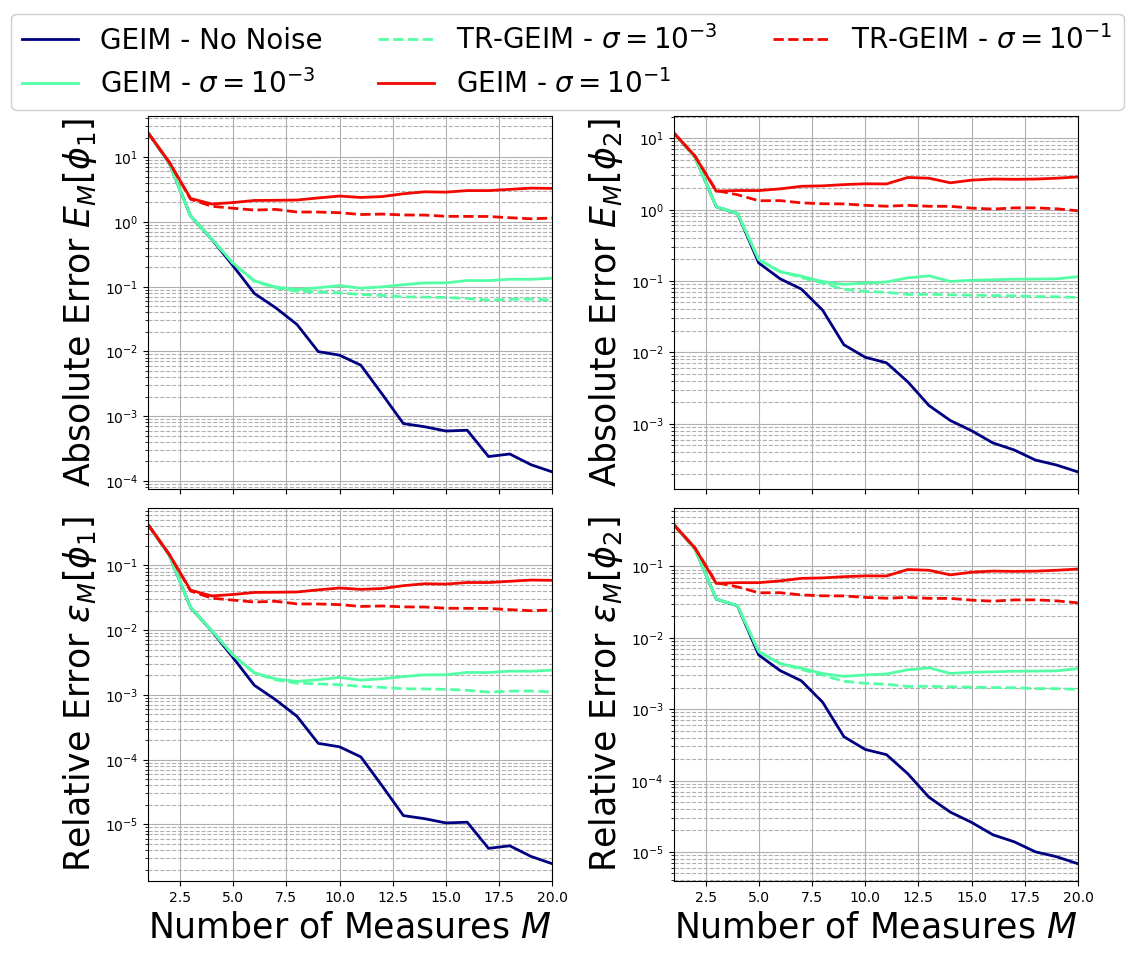

In [11]:
plot_errors(test_errors, Mmax, sigma, var_names, tex_var_names)

The important thing to observe is that the GEIM algorithm is unstable in presence of random noise: the errors diverges and do not show a good trend towards convergence. This effect becomes more and more important as the level of noise increases.

The computational times have been saved in the dictionary `comput_time` for each algorithm, each entry is another dictionary for each field, and each element is a list for every value of noise: the keys for this variable are `Measure` (time to get the local data), `LinearSystem` (time to solve the linear system), `Errors` (time to compute the test error with respect to the high-fidelity solution).

In [12]:
comput_time['geim']['phi_1'][0].keys()

dict_keys(['Measure', 'LinearSystem', 'Errors'])

Let us plot the computational time required by the Online Phase using this helper function.

In [13]:
def plot_comput_times(comput_time, idx_noise, var_names, tex_var_names, s, sigma):

    # Initialize subplots
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))


    for idx_ax in range(len(axs)):
        algo = list(comput_time.keys())[idx_ax]
        
        # Iterate over field_i values
        colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
        for field_i, color in zip(range(len(var_names)), colors):
            means = []
            stds = []
            field = var_names[field_i]

            # Calculate mean and std for each key
            for key in list(comput_time[algo][field][idx_noise].keys()):
                mean = np.mean(np.mean(comput_time[algo][field][idx_noise][key], axis=0))
                std = np.std(np.mean(comput_time[algo][field][idx_noise][key], axis=0))
                means.append(mean)
                stds.append(std)

            # Plot the bar chart with error bars for standard deviation
            bar_width = 0.2  # Adjust as needed
            ind = np.arange(len(list(comput_time[algo][field][idx_noise].keys())))
            bars = axs[idx_ax].bar(ind + (field_i - len(var_names) / 4) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)
        
        if idx_ax == 0:
            axs[idx_ax].set_ylabel(r'CPU Time (s)', fontsize=20)
            axs[idx_ax].set_title(r'GEIM - $s={:.2f}$'.format(s)+' and $\sigma= 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$', fontsize=20)
        else:
            axs[idx_ax].set_title(r'TR-GEIM - $s={:.2f}$'.format(s)+' and $\sigma= 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$', fontsize=20)
            
        axs[idx_ax].set_xticks(ind)
        axs[idx_ax].set_xticklabels(list(comput_time[algo][field][idx_noise].keys()))
        axs[idx_ax].legend(framealpha=1, fontsize=20)
        axs[idx_ax].tick_params(axis='both', labelsize=18)
        axs[idx_ax].grid()
        
    plt.tight_layout()

Only a single value of noise will be plotted for the sake of clarity.

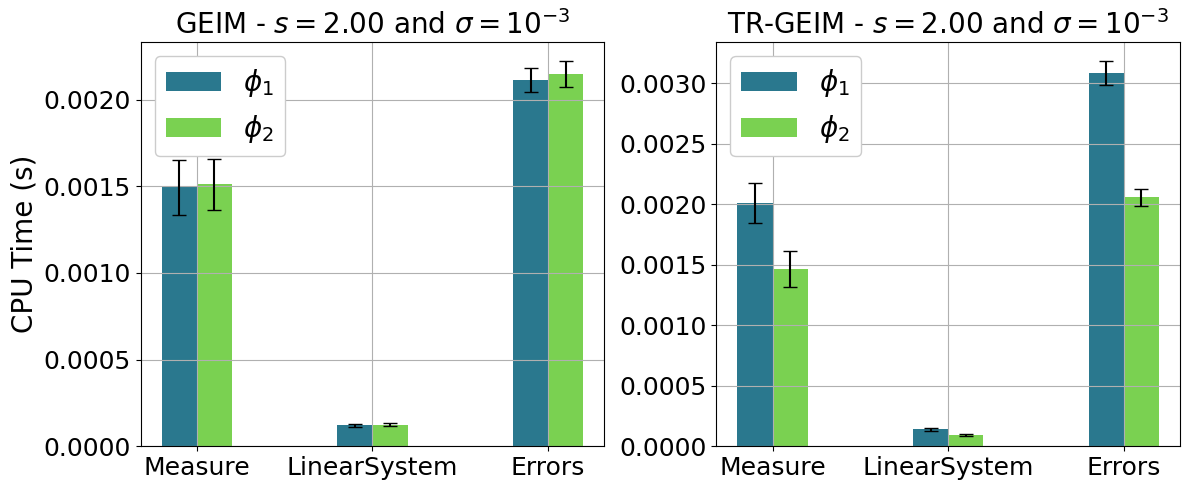

In [14]:
plot_comput_times(comput_time, 1, var_names, tex_var_names, s, sigma)

### Plotting the interpolant and the residual fields
Using *pyvista* and some additional functions the interpolant and its residual field $r[u] = | u - \mathcal{P}[u]|$ is plotted.

Let us reconstruct one of the fields for the whole test set, using some functions of the *GEIM* and *TR-GEIM* classes: adopting the `reconstruct` method for all the snapshot of the test set, they need the snapshot, the number of sensors to use, the noise value and the `reg_param` for the `TRGEIM` class. The first output of this method is the reconstructed field.

In [20]:
Mmax = 20

noise_value = 1e-2

rom_recs = list()

for field_i in range(len(var_names)):
    field = var_names[field_i]
    
    rom_recs.append({'GEIM': FunctionsList(V),
                    'TR-GEIM': FunctionsList(V)})

    for mu in range(len(test_snaps[field_i])):
        out_geim = geim_online[field].reconstruct(test_snaps[field_i](mu), M = Mmax, noise_value = noise_value)
        rom_recs[field_i]['GEIM'].append(out_geim[0])

        out_trgeim = tr_geim_online[field].reconstruct(test_snaps[field_i](mu), M = Mmax, noise_value = noise_value, reg_param = noise_value**2)
        rom_recs[field_i]['TR-GEIM'].append(out_trgeim[0])
        
        del out_geim, out_trgeim

Let us use the `plot_FOM_vs_ROM` from `contour_plotting.py` to create contour plots

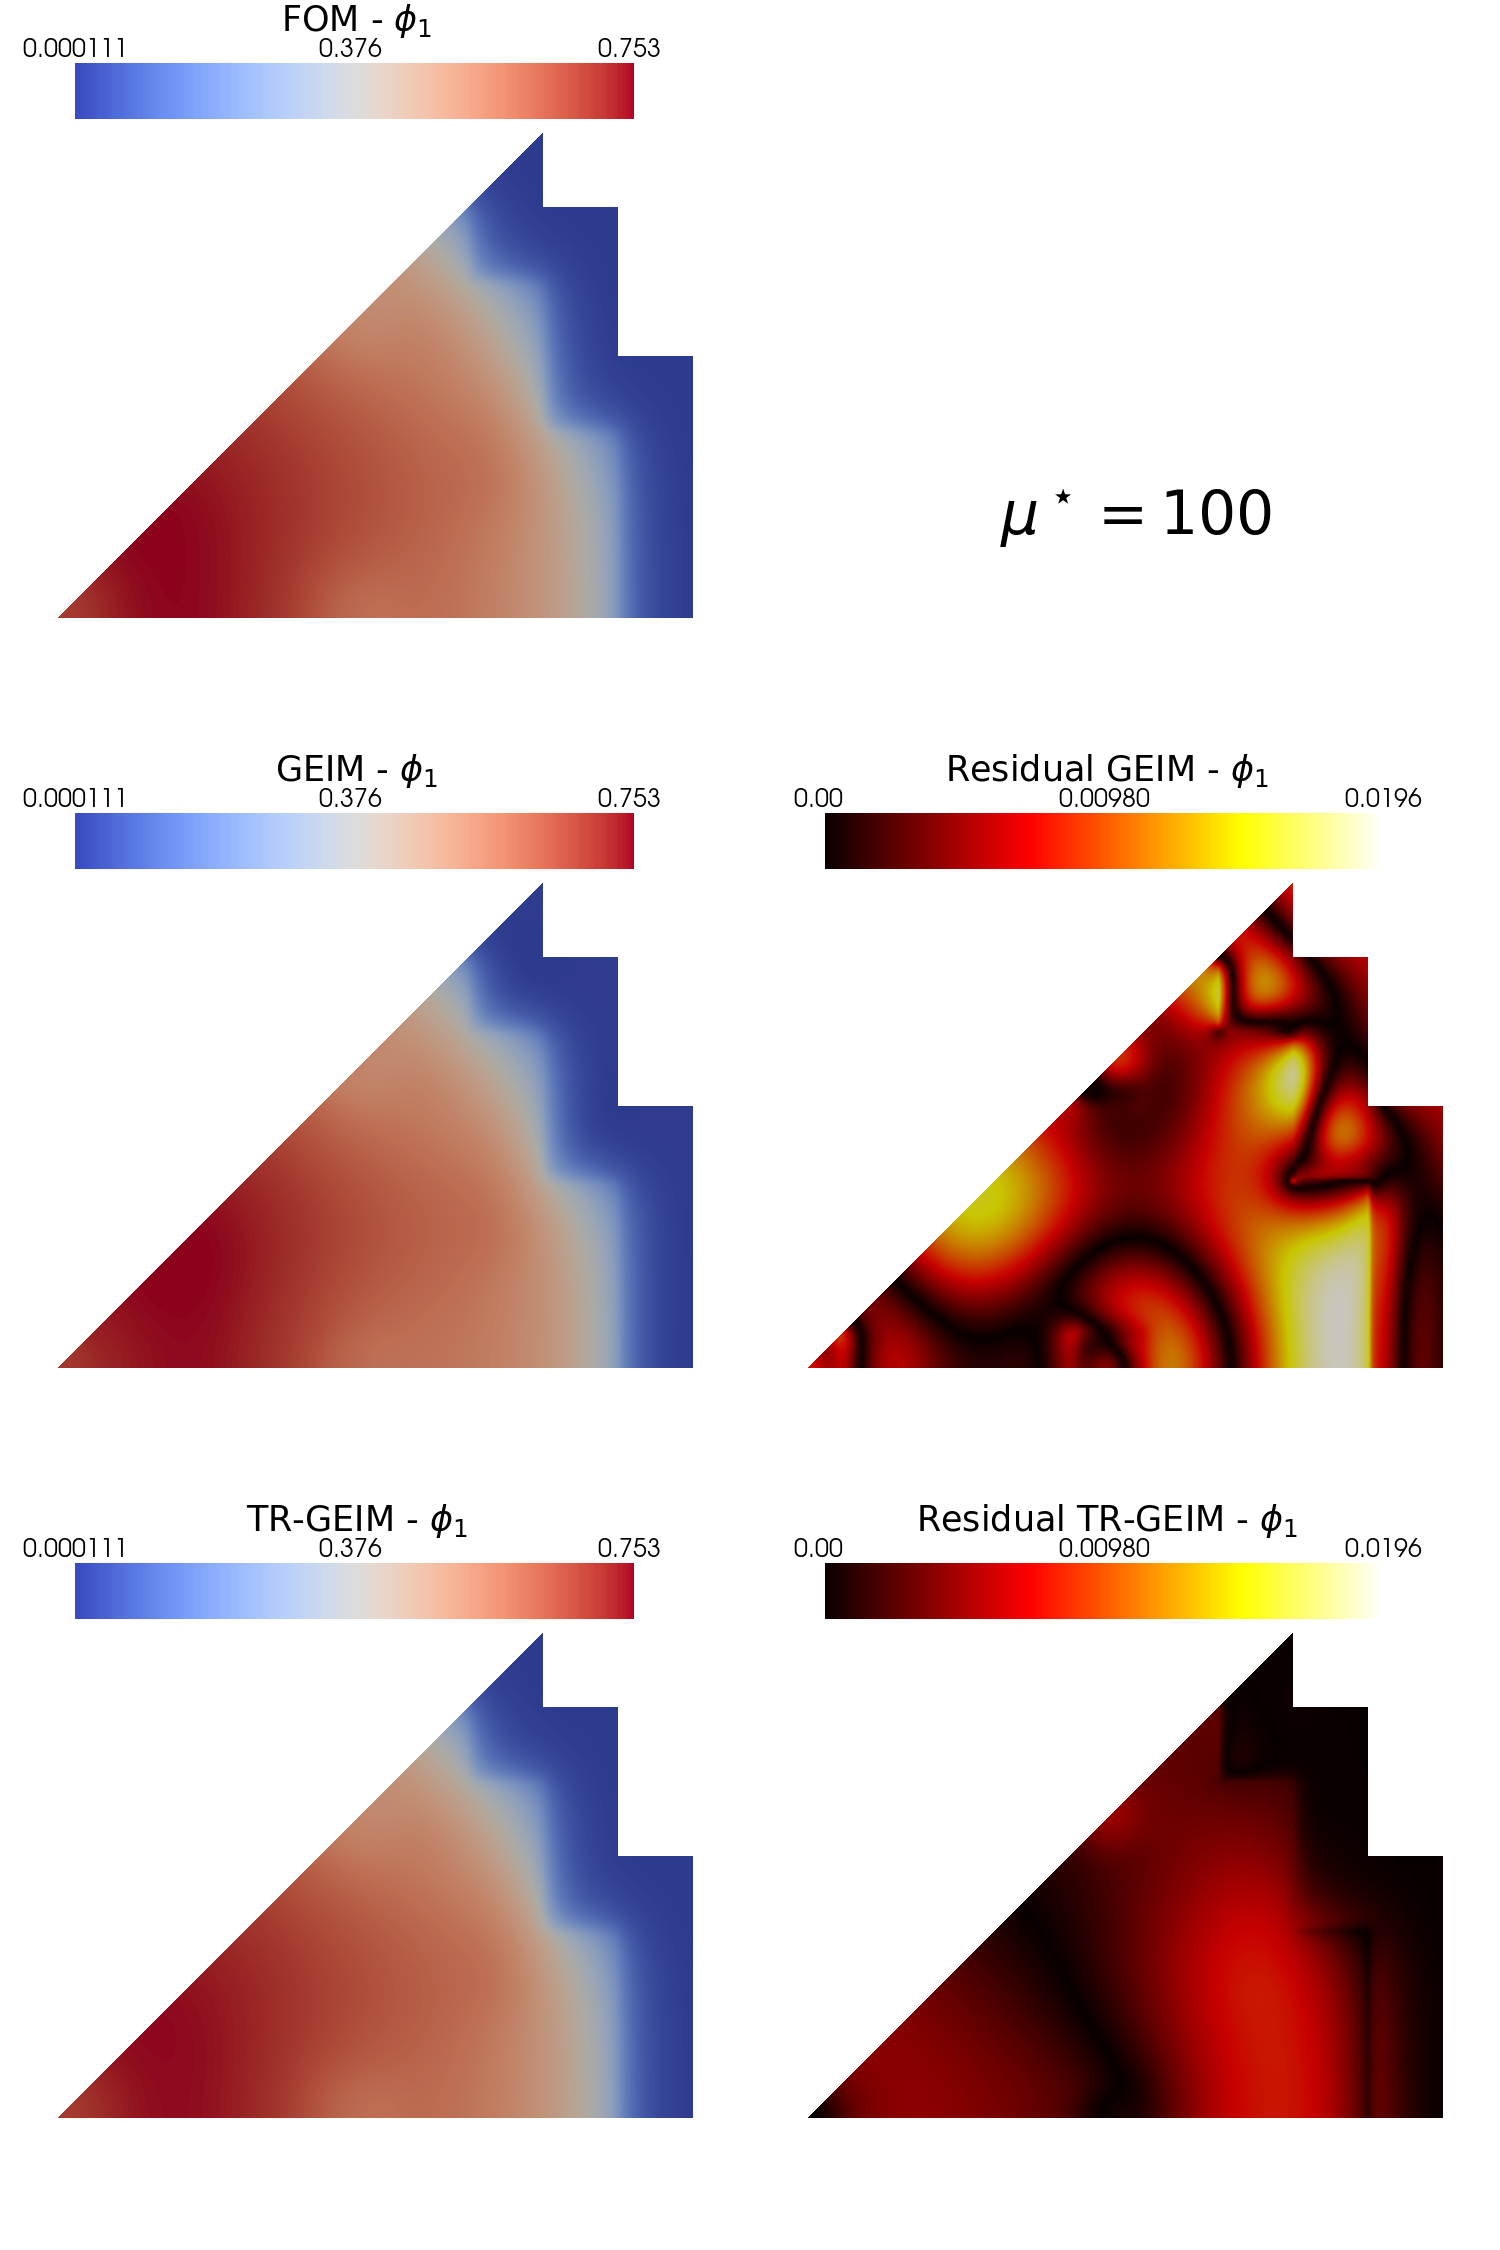

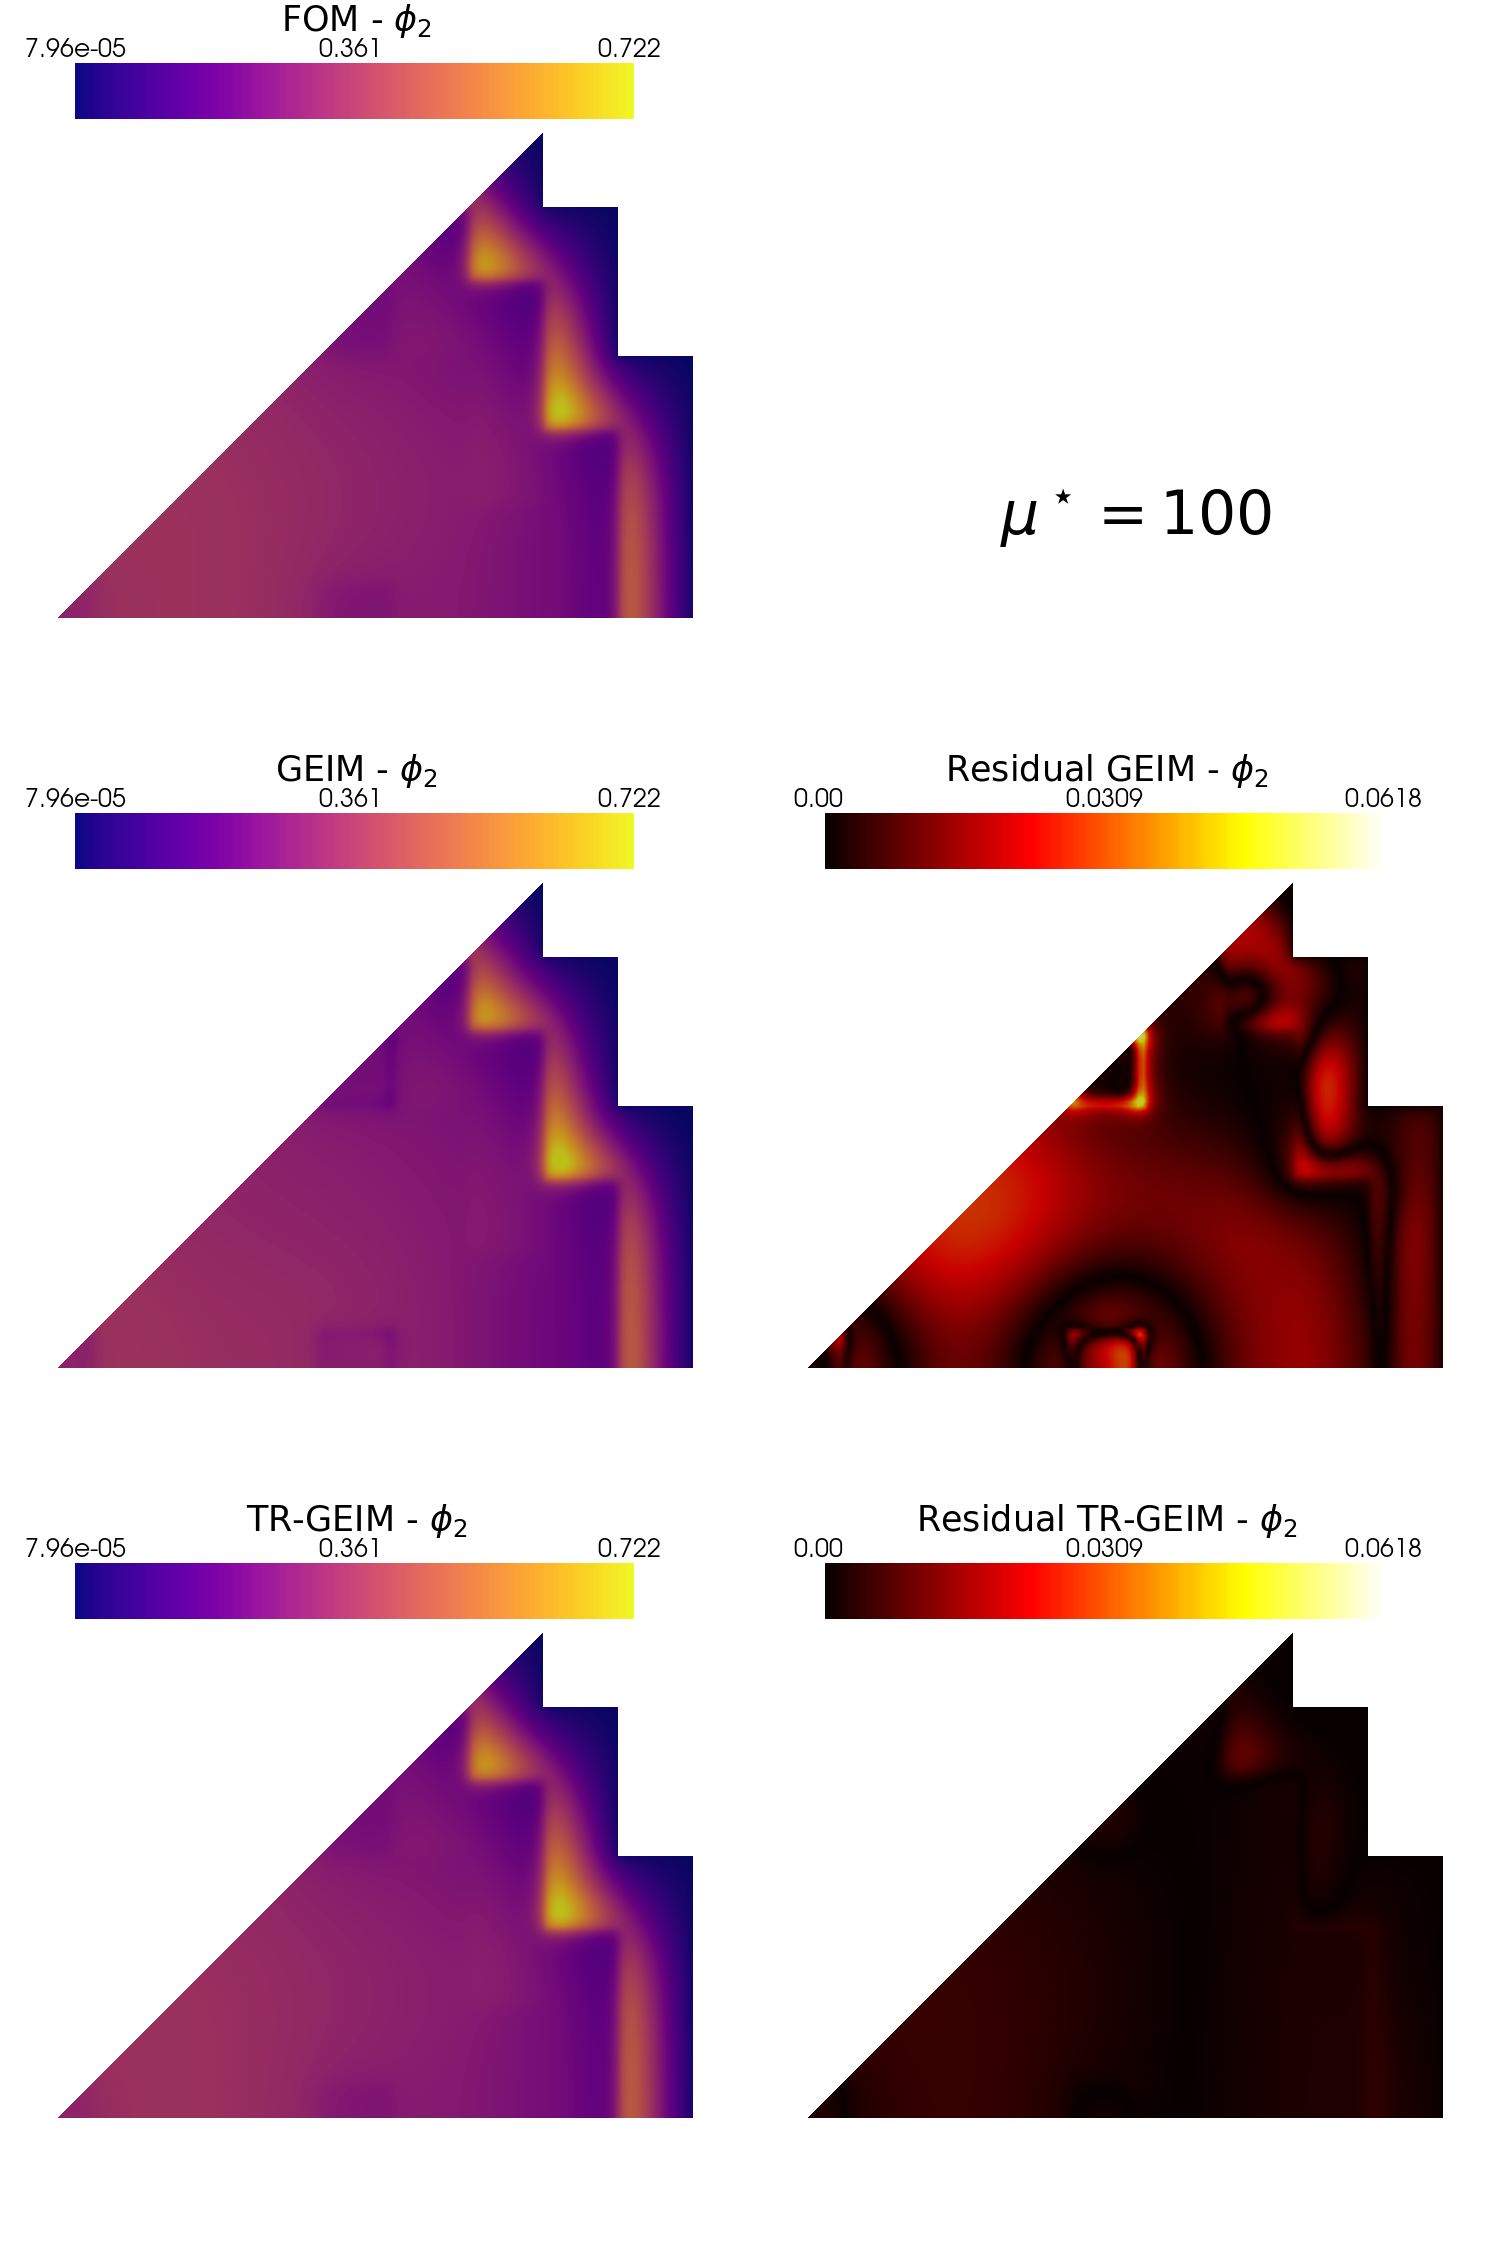

In [21]:
from contour_plotting import plot_FOM_vs_ROM

mu_to_plot = 100

plot_FOM_vs_ROM(test_snaps[0], rom_recs[0], mu_to_plot, 
                title=r'$\mu^\star='+str(mu_to_plot)+'$', varname=tex_var_names[0], 
                _resolution = [750,750], zoom = 1.1, position_cb=[0.1, 0.84],
                colormap=cm.coolwarm, colormap_res=cm.hot)

plot_FOM_vs_ROM(test_snaps[1], rom_recs[1], mu_to_plot, 
                title=r'$\mu^\star='+str(mu_to_plot)+'$', varname=tex_var_names[1], 
                _resolution = [750,750], zoom = 1.1, position_cb=[0.1, 0.84],
                colormap=cm.plasma, colormap_res=cm.hot)

Let us compare the fast and thermal flux with respect to some benchmark data. We are going to use the `extract_cells` function to extract the values of the fields on a specific lines.

In [22]:
from contour_plotting import extract_cells

Nhplot = 1000
xMax = 170
x_line = np.linspace(0, xMax + 1e-20, Nhplot)
points = [np.zeros((3, Nhplot)), 
          np.zeros((3, Nhplot))]
points[0][0] = x_line
points[1][0] = x_line
points[1][1] = x_line

extracted = [extract_cells(domain, point) for point in points]

Among the test snapshots there is one belonging to a neutronic benchmark, the results of the GEIM and TR-GEIM algorithms will be compared with the high-fidelity solution and the benchmark data.

In [23]:
import pandas as pd

bench_path = '..//BenchmarkData/MGDiffusion_ANL11A2/anl11a2_data.xlsx'

bench_data = [pd.read_excel(bench_path, sheet_name='x-axis').to_numpy()/1000, 
              pd.read_excel(bench_path, sheet_name='Diagonal').to_numpy()/1000]

bench_labels = [r'$y=x$', r'$y=0$']

Let us make a plot over lines for the fast and thermal fluxes.

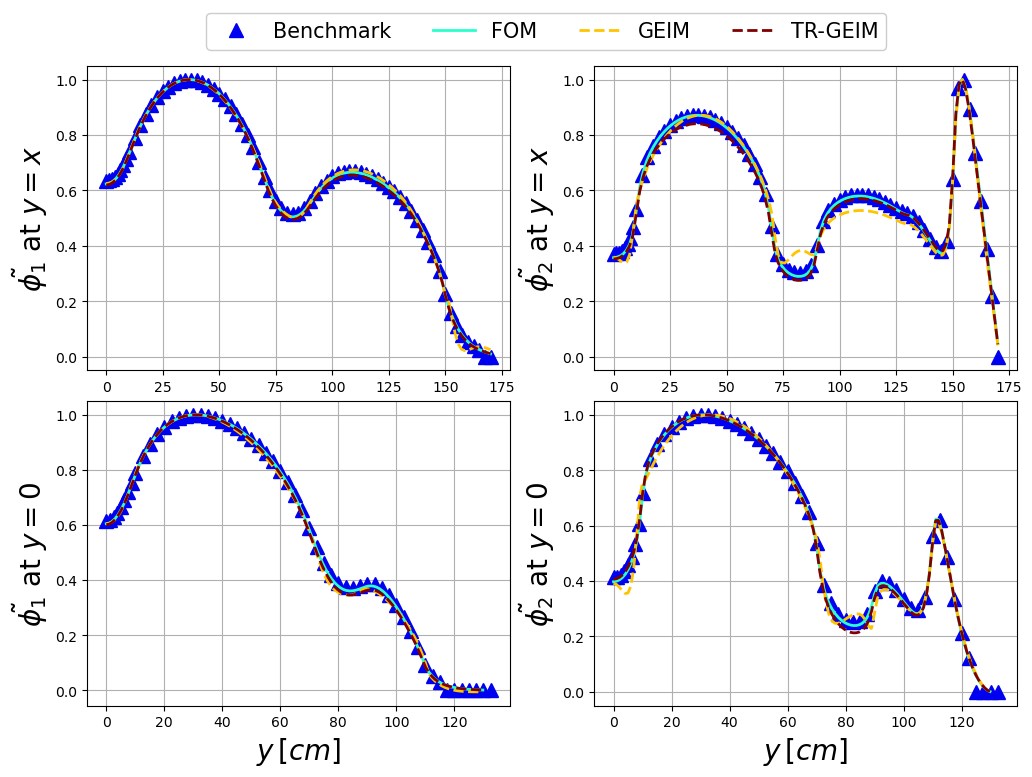

In [24]:
mark_size = 10
ls = 2
tickssize = 20

mu_bench = 220

fluxFigure, axs = plt.subplots(nrows = 2, ncols = len(var_names), figsize=(6 * len(var_names), 8))

for bench_i in range(2):
    xPlot = extracted[bench_i][0]
    cells = extracted[bench_i][1]
    for field_i in range(len(var_names)):
        colors = cm.jet(np.linspace(0.1,1, len(list(rom_recs[field_i].keys()))+2))
        axs[bench_i, field_i].plot(bench_data[bench_i][:, 0], bench_data[bench_i][:, field_i+bench_i+1] / max(bench_data[bench_i][:, field_i+bench_i+1]), '^', 
                                   c=colors[0], label = r'Benchmark', markersize=mark_size)
        axs[bench_i, field_i].plot(xPlot[:,0], test_snaps[field_i].map(mu_bench).eval(xPlot, cells) / max(test_snaps[field_i].map(mu_bench).eval(xPlot, cells)),
                                   c=colors[1], label = r'FOM', linewidth=ls)
        
        for algo_i, algo in enumerate(list(rom_recs[field_i].keys())):
            axs[bench_i, field_i].plot(xPlot[:,0], rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells) / max(rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells)),
                                       '--', c=colors[2+algo_i], label = algo, linewidth=ls)
            

        axs[bench_i, field_i].grid(which='major',linestyle='-')
        axs[bench_i, field_i].grid(which='minor',linestyle='--')
        axs[bench_i, field_i].set_ylabel(r"$\tilde{"+tex_var_names[field_i]+"}$ at "+bench_labels[bench_i], fontsize=20)
        
        if bench_i + 1 == 2:
            axs[bench_i, field_i].set_xlabel(r"$y\,[cm]$",fontsize=20)    
        
Lines, Labels = axs[0,0].get_legend_handles_labels()
fluxFigure.legend(Lines, Labels, framealpha=1, loc=(0.2, 0.935), ncols = 2+len(rom_recs[0]), fontsize=15)
fluxFigure.subplots_adjust(wspace=0.2, hspace=0.1, top = 0.91)